In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from zipfile import ZipFile
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [2]:
!pip install kaggle

In [3]:
# Don't forget to add kaggle.json to the directories
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d ashishjangra27/face-mask-12k-images-dataset

100% 329M/330M [00:16<00:00, 26.7MB/s]
100% 330M/330M [00:16<00:00, 21.4MB/s]


In [6]:
data = "/content/face-mask-12k-images-dataset.zip"

with ZipFile(data, 'r') as zip:
  zip.extractall()
  print('Succesfully Extract the Data')


Succesfully Extract the Data


In [27]:
train_with_mask = os.listdir('/content/Face Mask Dataset/Train/WithMask')
train_without_mask = os.listdir('/content/Face Mask Dataset/Train/WithoutMask')
validation_with_mask = os.listdir('/content/Face Mask Dataset/Validation/WithMask')
validation_without_mask = os.listdir('/content/Face Mask Dataset/Validation/WithoutMask')
print(train_with_mask[:5])
print(train_without_mask[-5:])
print(f'total training images : {len(train_with_mask)+len(train_without_mask)}')
print(f'total validation images : {len(validation_with_mask)+len(validation_without_mask)}')

['Augmented_851_4702727.png', 'Augmented_849_52759.png', '1729.png', 'Augmented_76_156642.png', '1625.png']
['5621.png', '3743.png', '2959.png', '1368.png', '842.png']
total training images : 10000
total validation images : 800


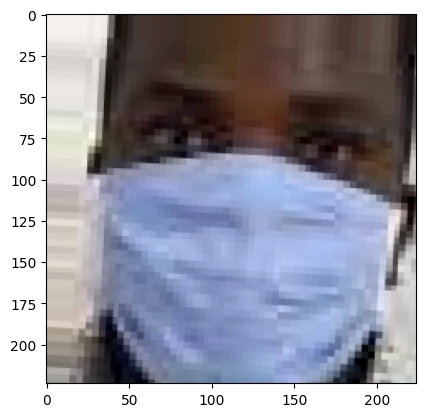

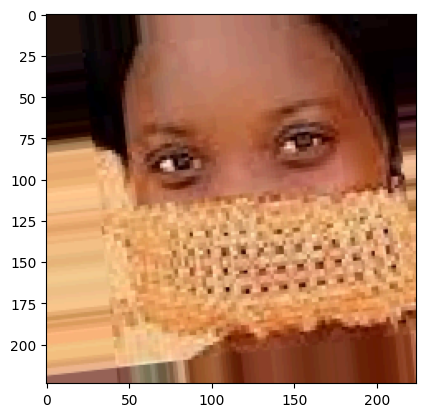

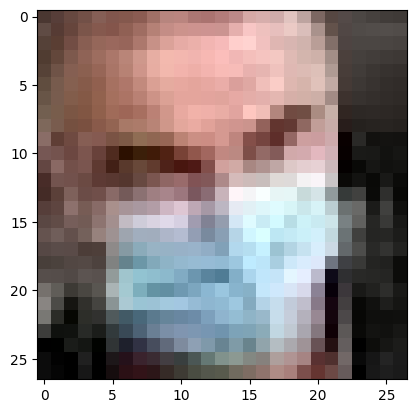

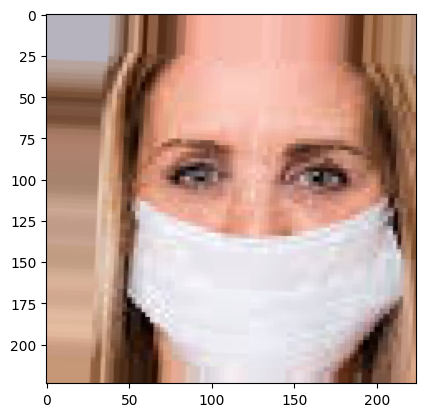

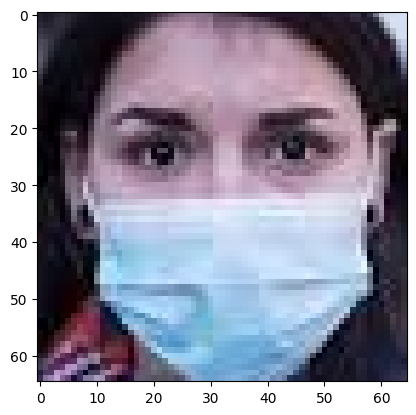

In [8]:
train_mask_path = '/content/Face Mask Dataset/Train/WithMask/'

for image in train_with_mask[:5]:
  img = mpimg.imread(train_mask_path + image)
  imgplot = plt.imshow(img)
  plt.show()

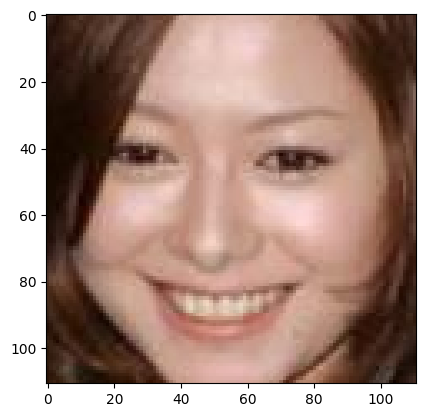

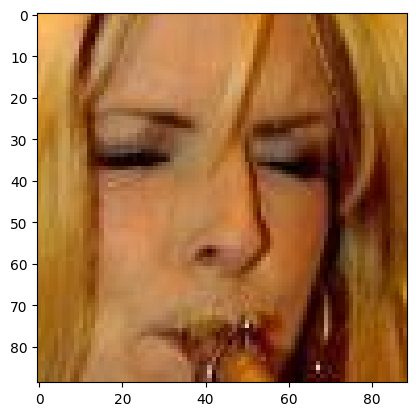

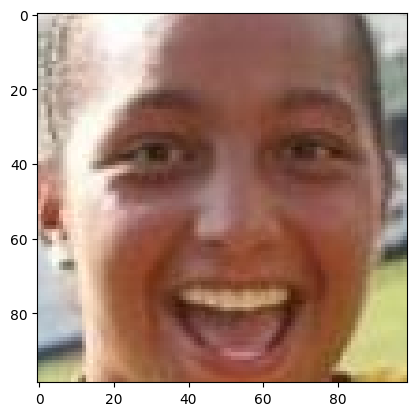

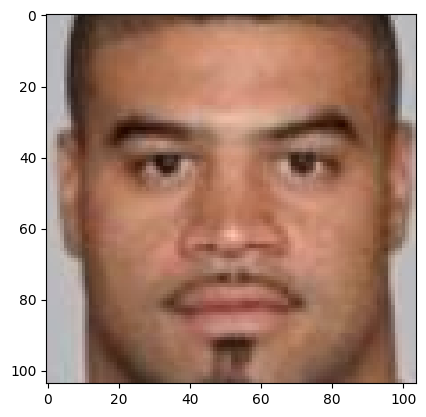

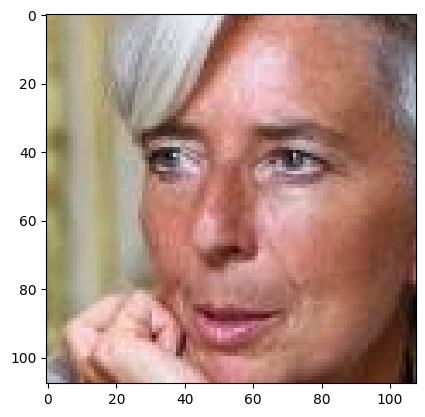

In [ ]:
train_nomask_path = '/content/Face Mask Dataset/Train/WithoutMask/'

for image in train_without_mask[:5]:
  img = mpimg.imread(train_nomask_path + image)
  imgplot = plt.imshow(img)
  plt.show()

In [9]:
TRAINING_DIR = "/content/Face Mask Dataset/Train"
VALIDATION_DIR = "/content/Face Mask Dataset/Validation"

train_datagen = ImageDataGenerator(rescale=1./255,
                                   horizontal_flip=True,
                                   shear_range=0.2,
                                   rotation_range=0.2,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   fill_mode='nearest',
                                   zoom_range=0.2)

train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                    batch_size=64,
                                                    target_size=(150,150),
                                                    class_mode='binary'
                                                    )

validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                              batch_size=64,
                                                              target_size=(150,150),
                                                              class_mode='binary'
                                                              )

Found 10000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


# TRANSFER LEARNING USING INCEPTIONV3

In [10]:
# Download the pre-trained weights. No top means it excludes the fully connected layer it uses for classification.
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2023-07-21 01:55:08--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.174.128, 74.125.23.128, 74.125.203.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.174.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M  25.8MB/s    in 3.8s    

2023-07-21 01:55:13 (22.2 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [19]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import layers

# Set the weights file you downloaded into a variable
local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

# Initialize the base model.
# Set the input shape and remove the dense layers.
pre_trained_model = InceptionV3(input_shape=(150,150,3),
                                include_top=False,
                                weights=None)

# Load the pre-trained weights you downloaded
pre_trained_model.load_weights(local_weights_file)

# Freeze the weights of the layers
for layer in pre_trained_model.layers:
  layer.trainable = False

In [ ]:
pre_trained_model.summary()

In [21]:
# Choose `mixed_7` as the last layer of your base model
last_layer = pre_trained_model.get_layer('mixed7')
print(f'last layer output shape = {last_layer.output_shape}')
last_output = last_layer.output

last layer output shape = (None, 7, 7, 768)


In [23]:
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import Model

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 512 hidden units and ReLU activation
x = layers.Dense(512, activation='relu')(x)
# Add a dropout rate of 0.4
x = layers.Dropout(0.4)(x)
# Add a fully connected layer with 128 hidden units and ReLU activation
x = layers.Dense(128, activation='relu')(x)
# Add a final sigmoid layer for binary classification
x = layers.Dense(1, activation='sigmoid')(x)

# Append the dense network to the base model
model = Model(pre_trained_model.input, x)

# Print the model summary. See your dense network connected at the end.
model.summary

<bound method Model.summary of <keras.engine.functional.Functional object at 0x7b0e7eff2440>>

In [24]:
class myCallBack(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if logs.get('accuracy')>0.9 and logs.get('val_accuracy')>0.9:
      print('\nDesired Accuracy & Validation Accuracy Achieved !')
      self.model.stop_training = True

callback = myCallBack()

In [25]:
model.compile(optimizer=RMSprop(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [26]:
(len(train_with_mask)+len(train_without_mask))/64

156.25

In [29]:
(len(validation_with_mask)+len(validation_without_mask))/64

12.5

In [30]:
history = model.fit(train_generator,
                    validation_data = validation_generator,
                    epochs=20,
                    verbose=2,
                    callbacks=[callback],
                    steps_per_epoch = 156,
                    validation_steps = 12
                    )

Epoch 1/20

Desired Accuracy & Validation Accuracy Achieved !
156/156 - 552s - loss: 0.0461 - accuracy: 0.9806 - val_loss: 0.0054 - val_accuracy: 0.9987 - 552s/epoch - 4s/step


In [31]:
TEST_DIR = "/content/Face Mask Dataset/Test"

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    batch_size=64,
    target_size=(150, 150),
    class_mode='binary',
    shuffle=False  # Set shuffle to False for the test set to keep the order of predictions
)

Found 992 images belonging to 2 classes.


In [32]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print("Test Accuracy:", test_accuracy)
print(f'Test Loss : {test_loss}')

16/16 [==============================] - 42s 3s/step - loss: 0.0043 - accuracy: 0.9990
Test Accuracy: 0.9989919066429138
Test Loss : 0.004271514248102903


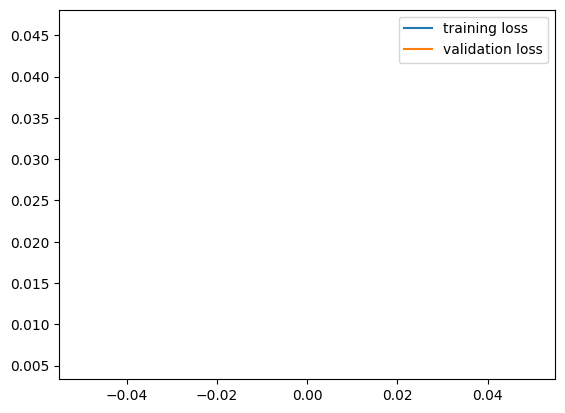

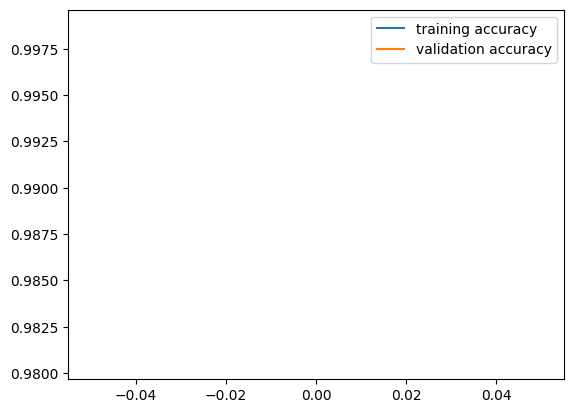

In [33]:
h = history
plt.plot(h.history['loss'], label='training loss')
plt.plot(h.history['val_loss'], label='validation loss')
plt.legend()
plt.show()

plt.plot(h.history['accuracy'], label='training accuracy')
plt.plot(h.history['val_accuracy'], label='validation accuracy')
plt.legend()
plt.show()

In [35]:
import numpy as np

# Predict on the test set
test_predictions = model.predict(test_generator)

# Post-process the predictions
test_predictions = np.squeeze(test_predictions)  # Remove unnecessary dimensions

# Print individual predictions and corresponding filenames
for i in range(len(test_generator.filenames)):
    filename = test_generator.filenames[i]
    probability = test_predictions[i]
    probability = 1.0 - probability # KARENA KEBALIK, CLOSE TO 1 DIANGGEP GA PAKE MASKER, CLOSE TO 0 DIANGGEP PAKE MASKER :(

    if probability >= 0.5:
        prediction = 'Mask Detected'
    else:
        prediction = 'Mask Not Detected'
    print(f"{filename}: {probability:.4f} - {prediction}")

16/16 [==============================] - 42s 3s/step
WithMask/1163.png: 0.2426 - Mask Not Detected
WithMask/1174.png: 1.0000 - Mask Detected
WithMask/1175.png: 0.9999 - Mask Detected
WithMask/1203.png: 1.0000 - Mask Detected
WithMask/1361.png: 1.0000 - Mask Detected
WithMask/1362.png: 0.9998 - Mask Detected
WithMask/1363.png: 0.9997 - Mask Detected
WithMask/1388.png: 1.0000 - Mask Detected
WithMask/1389.png: 1.0000 - Mask Detected
WithMask/1404.png: 1.0000 - Mask Detected
WithMask/1405.png: 1.0000 - Mask Detected
WithMask/1407.png: 0.9997 - Mask Detected
WithMask/1413.png: 1.0000 - Mask Detected
WithMask/1439.png: 0.9999 - Mask Detected
WithMask/147.png: 0.9999 - Mask Detected
WithMask/152.png: 1.0000 - Mask Detected
WithMask/153.png: 1.0000 - Mask Detected
WithMask/1558.png: 1.0000 - Mask Detected
WithMask/1559.png: 0.9994 - Mask Detected
WithMask/1565.png: 1.0000 - Mask Detected
WithMask/1573.png: 0.9994 - Mask Detected
WithMask/1606.png: 0.9999 - Mask Detected
WithMask/1607.png: 1.0

In [37]:
import numpy as np
from google.colab import files
from tensorflow.keras.utils import load_img, img_to_array

def preprocess_image(image_path):
    img = load_img(image_path, target_size=(150, 150))
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)

    # Create an instance of ImageDataGenerator for preprocessing
    datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
    x = datagen.standardize(x)

    return x

def display_input(probability):
  # Display the image with the prediction result
  img = load_img(path)
  plt.imshow(img)
  if probability >= 0.5:
    plt.title('Mask Detected')
  else:
    plt.title('Mask Not Detected')
  plt.axis('off')
  plt.show()

Saving Foto diri_Muhammad Raja Reivan Rivaldi.jpg to Foto diri_Muhammad Raja Reivan Rivaldi (2).jpg
1/1 [==============================] - 0s 80ms/step
Foto diri_Muhammad Raja Reivan Rivaldi (2).jpg
[[0.01025218]]
Mask Not Detected


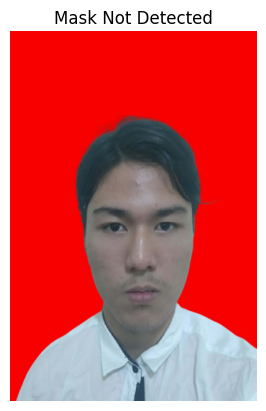

are you done? (y/n) n


Saving Screenshot (583).png to Screenshot (583) (2).png
1/1 [==============================] - 0s 90ms/step
Screenshot (583) (2).png
[[0.2881993]]
Mask Not Detected


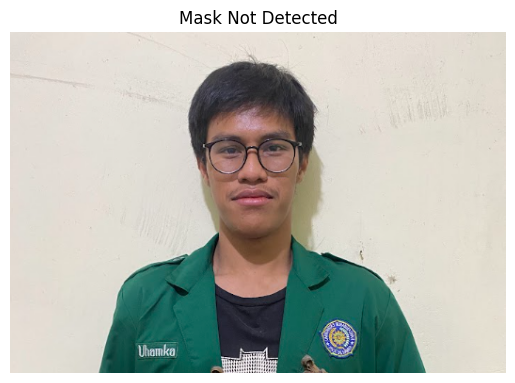

are you done? (y/n) n


Saving IMG_20230721_105109_436.jpg to IMG_20230721_105109_436.jpg
1/1 [==============================] - 0s 93ms/step
IMG_20230721_105109_436.jpg
[[0.9990698]]
Mask Detected


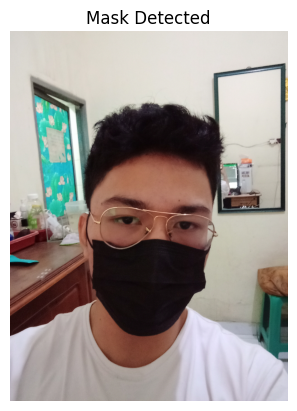

are you done? (y/n) y


In [39]:
while True:
  uploaded = files.upload()

  for fn in uploaded.keys():

    # predicting images
    path = fn
    preprocessed_image = preprocess_image(path)
    probability = model.predict(preprocessed_image)
    print(fn)



  probability = 1.0 - probability # KARENA KEBALIK, CLOSE TO 1 DIANGGEP GA PAKE MASKER, CLOSE TO 0 DIANGGEP PAKE MASKER :(
  print(probability)

  if probability > 0.5:
    print('Mask Detected')
  else:
    print('Mask Not Detected')

  display_input(probability)

  is_done = input('are you done? (y/n) ')

  if is_done == 'y' or is_done == 'Y':
    break

In [42]:
model.save('Mask_detection_withTL.h5')